In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy

In [3]:
df_raw: pd.DataFrame = pd.read_excel("ev-range.xlsx")
df_raw.head()

,Speed [mph],Range [mi]
0,2,154.4
1,4,248.6
2,6,309.3
3,8,349.7
4,10,376.4


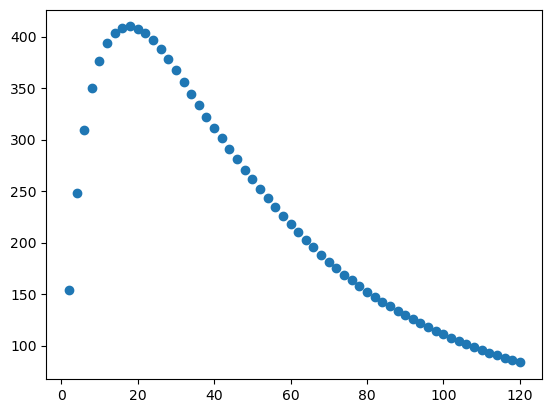

In [4]:
x = df_raw["Speed [mph]"]
y = df_raw["Range [mi]"]

plt.scatter(x, y)

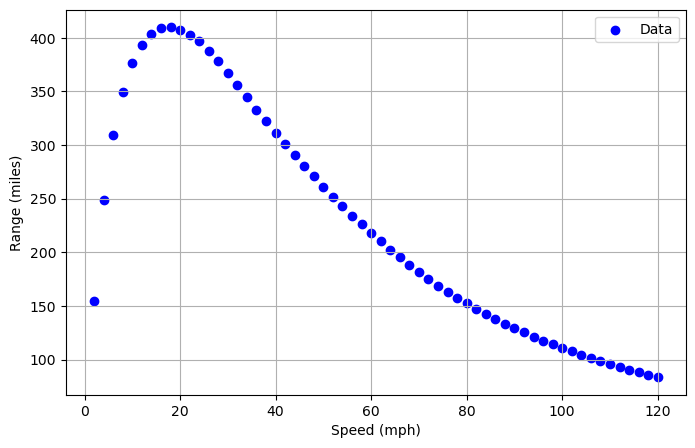

In [5]:
# Visualize the data using the correct column names
plt.figure(figsize=(8, 5))
plt.scatter(df_raw['Speed [mph]'], df_raw['Range [mi]'], color='blue', label='Data')
plt.xlabel('Speed (mph)')
plt.ylabel('Range (miles)')
plt.legend()
plt.grid(True)
plt.savefig("plots/raw_data.png")
plt.show()

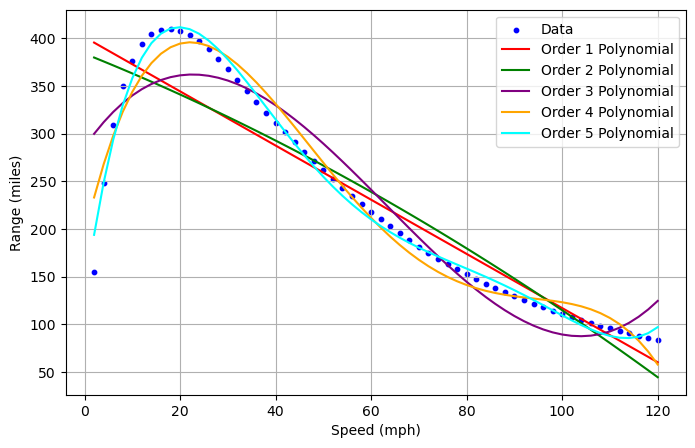

[2173.811316495322,
 2119.6223333101834,
 1003.1537150157565,
 313.26215510237193,
 83.001704794938]

In [6]:
from numpy.polynomial import Polynomial
from sklearn.metrics import mean_squared_error

# Extract the Speed and Range data for fitting
x = df_raw['Speed [mph]'].values
y = df_raw['Range [mi]'].values

# Lists to store results
polynomials = []
mse_values = []

# Fit polynomials of different orders and calculate their MSE
for order in range(1, 6):
    p = Polynomial.fit(x, y, order)
    y_pred = p(x)
    mse = mean_squared_error(y, y_pred)
    
    polynomials.append(p)
    mse_values.append(mse)

# Plot the data and the fitted curves
plt.figure(figsize=(8, 5))
plt.scatter(x, y, color='blue', label='Data', s=10)
colors = ['red', 'green', 'purple', 'orange', 'cyan']
for order, (p, color) in enumerate(zip(polynomials, colors), 1):
    plt.plot(x, p(x), color=color, label=f'Order {order} Polynomial')

plt.xlabel('Speed (mph)')
plt.ylabel('Range (miles)')
plt.legend()
plt.grid(True)
plt.savefig("plots/polynomial_fits.png")
plt.show()

mse_values

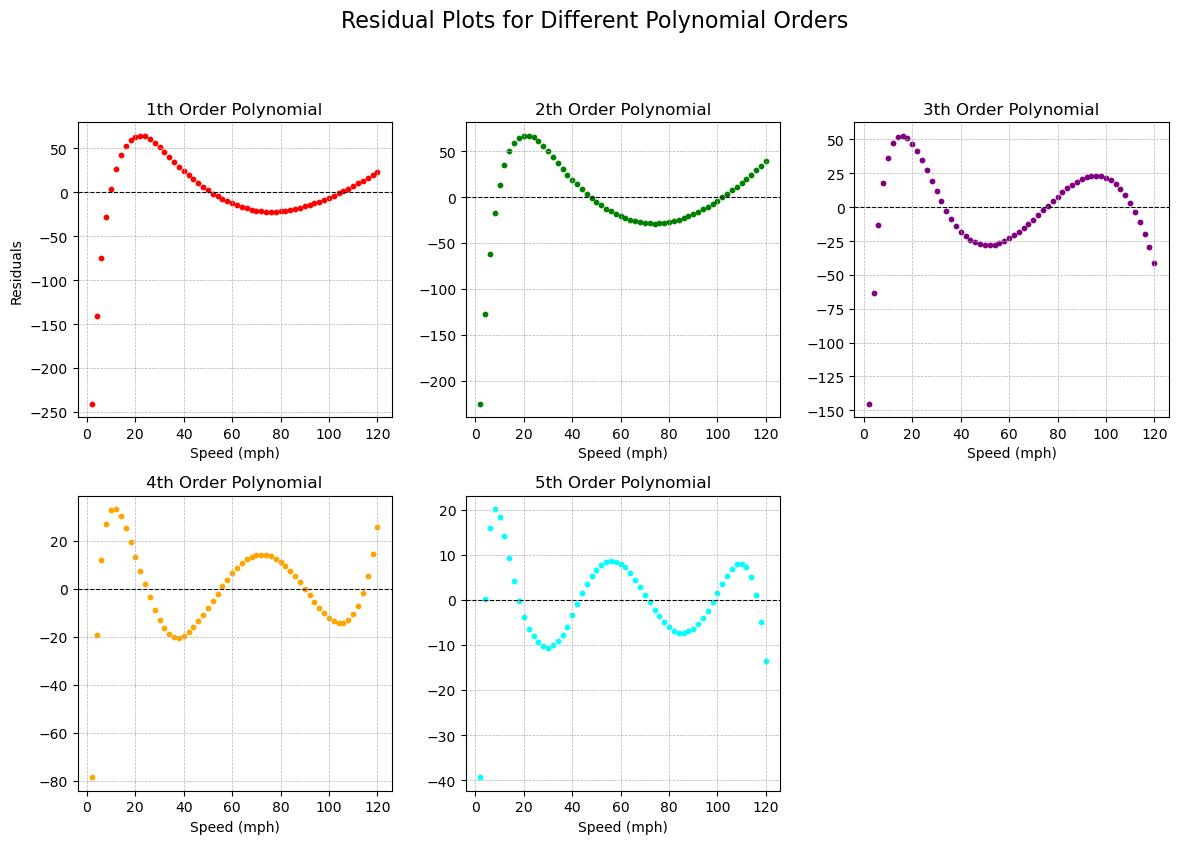

In [7]:
# Plot the residuals for each polynomial fit in a presentable manner
plt.figure(figsize=(12, 8))

for order, (p, color) in enumerate(zip(polynomials, colors), 1):
    residuals = y - p(x)
    ax = plt.subplot(2, 3, order)
    ax.scatter(x, residuals, color=color, s=10)
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.set_title(f'{order}th Order Polynomial')
    ax.set_xlabel('Speed (mph)')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Set y-label only for the first plot for clarity
    if order == 1:
        ax.set_ylabel('Residuals')

plt.suptitle('Residual Plots for Different Polynomial Orders', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


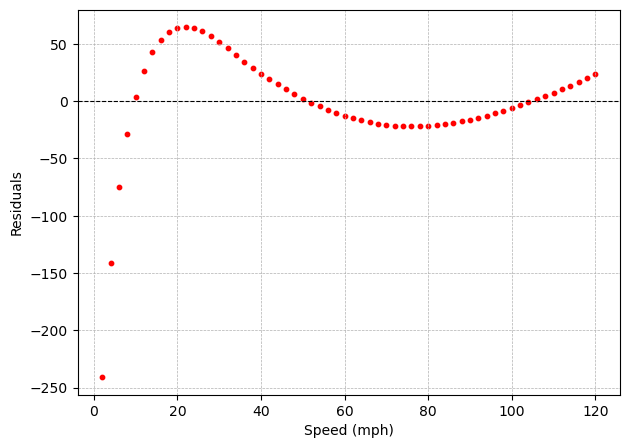

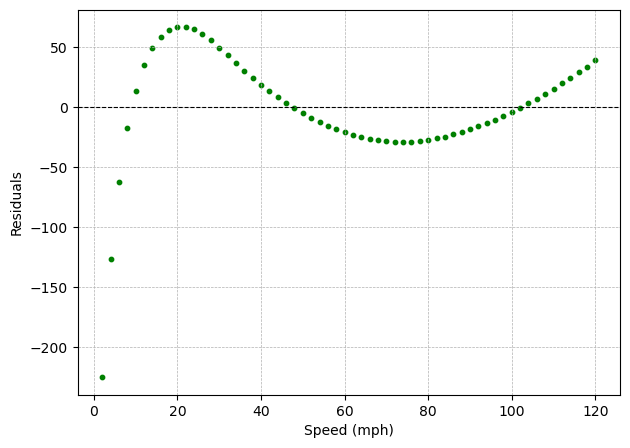

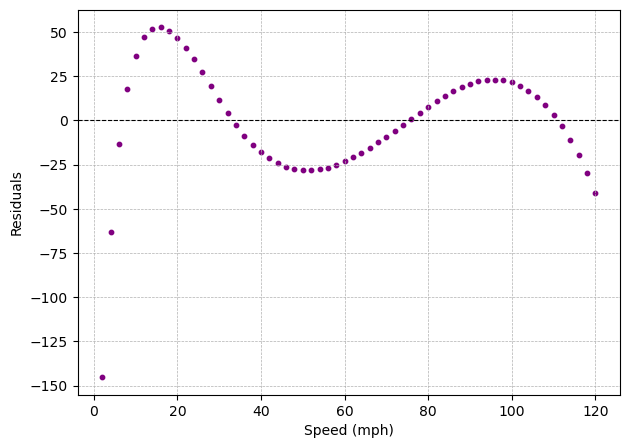

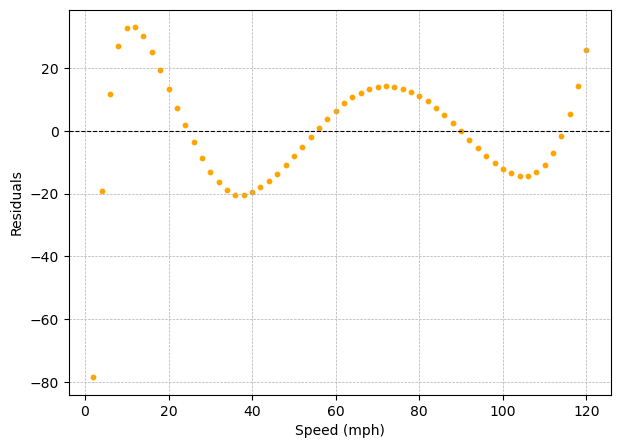

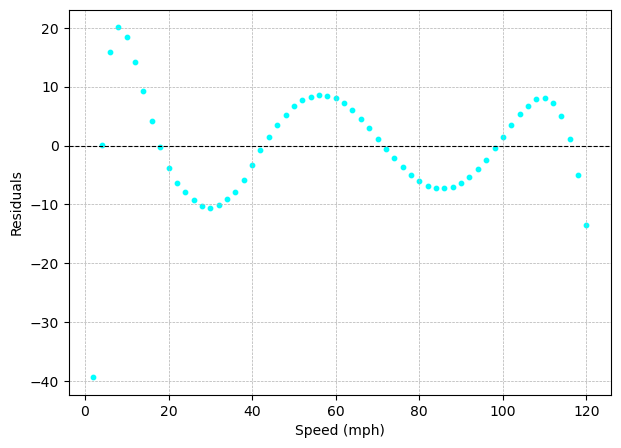

In [8]:
# Function to plot individual residuals for a given polynomial order
def plot_residuals_for_order(order, p, color, index):
    residuals = y - p(x)
    plt.figure(figsize=(7, 5))
    plt.scatter(x, residuals, color=color, s=10)
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.xlabel('Speed (mph)')
    plt.ylabel('Residuals')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.savefig(f"plots/residual_plot_deg_{index}.png")
    plt.show()

# Plot residuals for each polynomial order individually
index = 1
for order, (p, color) in enumerate(zip(polynomials, colors), 1):
    plot_residuals_for_order(order, p, color, index)
    index += 1

In [9]:
from scipy.stats import f

def corrected_fisher_test(y, model1, order1, model2, order2):
    """
    Perform the corrected Fisher test comparing two models.
    
    Parameters:
    - y: observed values
    - model1: predicted values from the simpler model
    - order1: order of the simpler model
    - model2: predicted values from the more complex model
    - order2: order of the more complex model
    
    Returns:
    - F-statistic
    - p-value
    """
    # Residual sum of squares
    rss1 = sum((y - model1)**2)
    rss2 = sum((y - model2)**2)
    
    # Degrees of freedom
    df1 = len(y) - (order1 + 1)
    df2 = len(y) - (order2 + 1)
    
    # F-statistic
    F = ((rss1 - rss2) / (df1 - df2)) / (rss2 / df2)
    
    # p-value
    p_value = 1 - f.cdf(F, df1 - df2, df2)
    
    return F, p_value

# Perform the corrected Fisher tests comparing the polynomial models
corrected_f_values = []
corrected_p_values = []

for i in range(4):
    F, p_value = corrected_fisher_test(y, polynomials[i](x), i+1, polynomials[i+1](x), i+2)
    corrected_f_values.append(F)
    corrected_p_values.append(p_value)

corrected_f_values, corrected_p_values

([1.457227541440932, 62.32568517528336, 121.1255020027436, 149.80492686651124],
 [0.2323574260334853,
  1.1525813636836801e-10,
  1.6653345369377348e-15,
  1.1102230246251565e-16])

In [10]:
import scipy.stats as stats

def compare_nested(x, y, simple_poly, complex_poly):
    N = len(x)

    # Calculate residuals for simple polynomial
    simple_y_pred = simple_poly(x)
    simple_res = simple_y_pred - y
    simple_dof = N - (simple_poly.degree() + 1) # Degree + 1 for polynomial coefficients
    simple_ssres = np.sum(simple_res**2)

    # Calculate residuals for complex polynomial
    complex_y_pred = complex_poly(x)
    complex_res = complex_y_pred - y
    complex_dof = N - (complex_poly.degree() + 1)
    complex_ssres = np.sum(complex_res**2)

    # Calculate F-number and get P-value
    fnum = ((simple_ssres - complex_ssres) / (simple_dof - complex_dof)) / (complex_ssres / complex_dof)
    pval = stats.f.sf(fnum, simple_dof - complex_dof, complex_dof)

    # Report and return results
    mstring = "complex" if pval < .05 else "simple"
    print('F-test comparing (simple) vs. (complex)')
    print('')
    print('  Simple:   SS=%8f, DOF=%4d' % (simple_ssres, simple_dof) )
    print('  Complex:  SS=%8f, DOF=%4d' % (complex_ssres, complex_dof) )
    print('  F-number: %1.4f ' % (fnum) )
    print('  P-value:  %1.4f ' % (pval) )
    print('  Random?   %1.3f%%' % (pval*100))
    print('')
    print('It is recommended to prefer the %s function.' % (mstring))
    print('')

    return fnum, pval


# Use the function for comparing polynomials
for i in range(4):
    compare_nested(x, y, polynomials[i], polynomials[i+1])

F-test comparing (simple) vs. (complex)

  Simple:   SS=130428.678990, DOF=  58
  Complex:  SS=127177.339999, DOF=  57
  F-number: 1.4572 
  P-value:  0.2324 
  Random?   23.236%

It is recommended to prefer the simple function.

F-test comparing (simple) vs. (complex)

  Simple:   SS=127177.339999, DOF=  57
  Complex:  SS=60189.222901, DOF=  56
  F-number: 62.3257 
  P-value:  0.0000 
  Random?   0.000%

It is recommended to prefer the complex function.

F-test comparing (simple) vs. (complex)

  Simple:   SS=60189.222901, DOF=  56
  Complex:  SS=18795.729306, DOF=  55
  F-number: 121.1255 
  P-value:  0.0000 
  Random?   0.000%

It is recommended to prefer the complex function.

F-test comparing (simple) vs. (complex)

  Simple:   SS=18795.729306, DOF=  55
  Complex:  SS=4980.102288, DOF=  54
  F-number: 149.8049 
  P-value:  0.0000 
  Random?   0.000%

It is recommended to prefer the complex function.



In [11]:
compare_nested(x, y, polynomials[0], polynomials[4])

F-test comparing (simple) vs. (complex)

  Simple:   SS=130428.678990, DOF=  58
  Complex:  SS=4980.102288, DOF=  54
  F-number: 340.0645 
  P-value:  0.0000 
  Random?   0.000%

It is recommended to prefer the complex function.



(340.0644580456448, 1.3842849470751226e-37)

In [12]:
polynomials[-1]

Polynomial([ 206.41344674, -204.97750864,  262.68106953, -210.55900288,
       -323.67213064,  367.18602786], domain=[  2., 120.], window=[-1.,  1.], symbol='x')

In [13]:
polynomials_1 = deepcopy(polynomials)

In [14]:
# Calculate consumption per mile (Ci)
df_raw['Consumption_per_mile'] = 55 / df_raw['Range [mi]']

# Fit polynomial models of degree 1 to 5
polynomials_2 = []
for degree in range(5):
    model = Polynomial.fit(df_raw['Speed [mph]'], df_raw['Consumption_per_mile'], degree)
    polynomials_2.append(model)

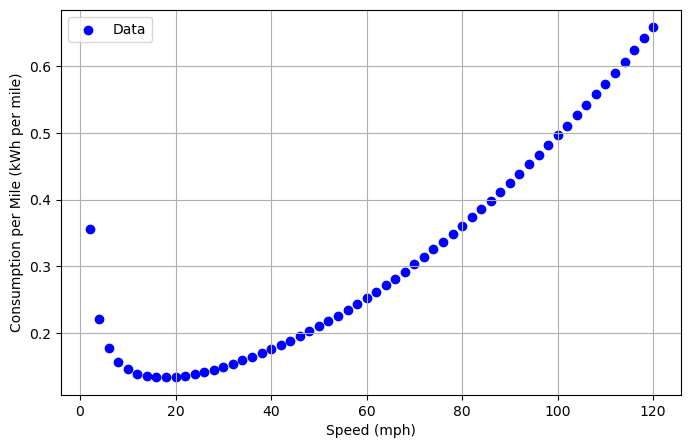

In [15]:
# Visualize the data using the correct column names
plt.figure(figsize=(8, 5))
plt.scatter(df_raw['Speed [mph]'], df_raw['Consumption_per_mile'], color='blue', label='Data')
plt.xlabel('Speed (mph)')
plt.ylabel('Consumption per Mile (kWh per mile)')
plt.legend()
plt.grid(True)
plt.savefig("plots/raw_data_2.png")
plt.show()

In [16]:
df_raw[df_raw["Speed [mph]"] == 18]

,Speed [mph],Range [mi],Consumption_per_mile
8,18,409.8,0.134212


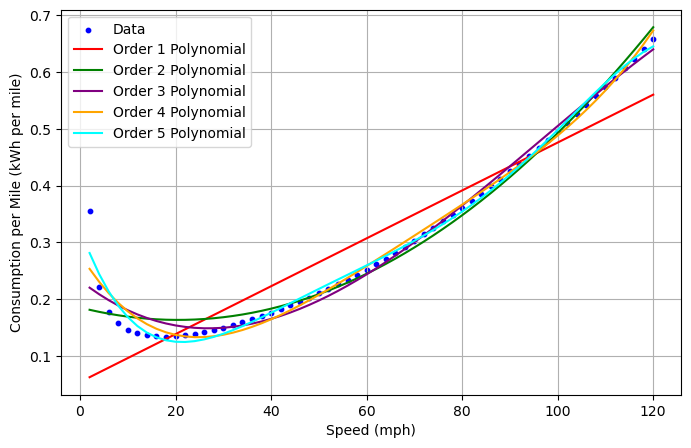

Polynomial([ 0.26372751,  0.24621304,  0.0387138 ,  0.19694452,  0.16095463,
       -0.26116546], domain=[  2., 120.], window=[-1.,  1.], symbol='x')

In [17]:
# Extract the Speed and Range data for fitting
x = df_raw['Speed [mph]'].values
y = df_raw['Consumption_per_mile'].values

# Lists to store results
polynomials = []
mse_values = []

# Fit polynomials of different orders and calculate their MSE
for order in range(1, 6):
    p = Polynomial.fit(x, y, order)
    y_pred = p(x)
    mse = mean_squared_error(y, y_pred)
    
    polynomials.append(p)
    mse_values.append(mse)

# Plot the data and the fitted curves
plt.figure(figsize=(8, 5))
plt.scatter(x, y, color='blue', label='Data', s=10)
colors = ['red', 'green', 'purple', 'orange', 'cyan']
for order, (p, color) in enumerate(zip(polynomials, colors), 1):
    plt.plot(x, p(x), color=color, label=f'Order {order} Polynomial')

plt.xlabel('Speed (mph)')
plt.ylabel('Consumption per Mile (kWh per mile)')
plt.legend()
plt.grid(True)
plt.savefig("plots/polynomial_fits_2.png")
plt.show()

mse_values
polynomials[-1]

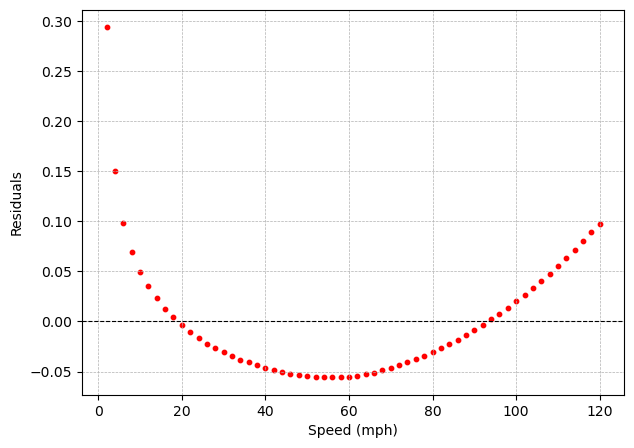

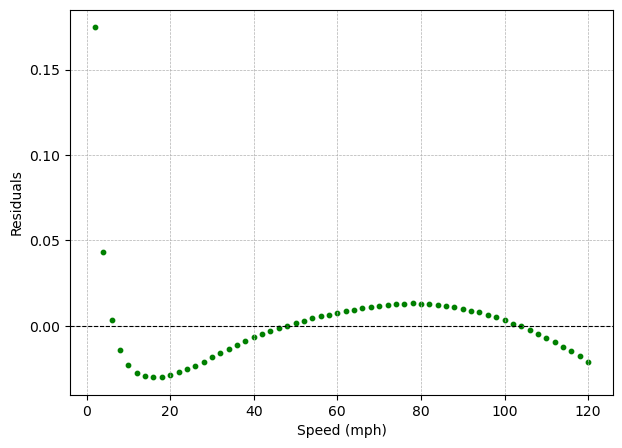

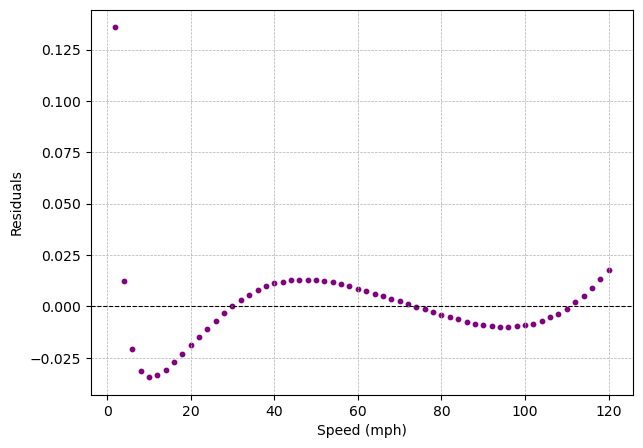

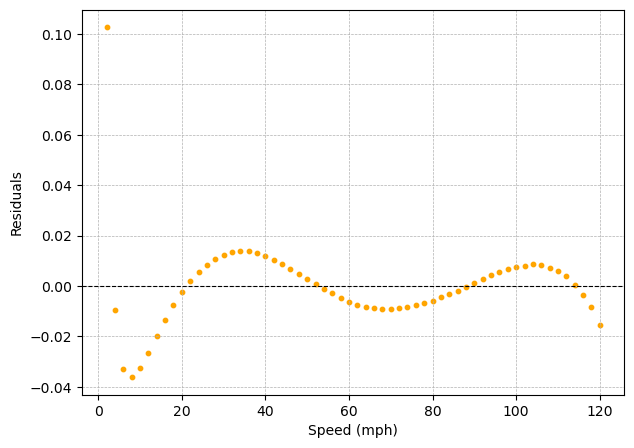

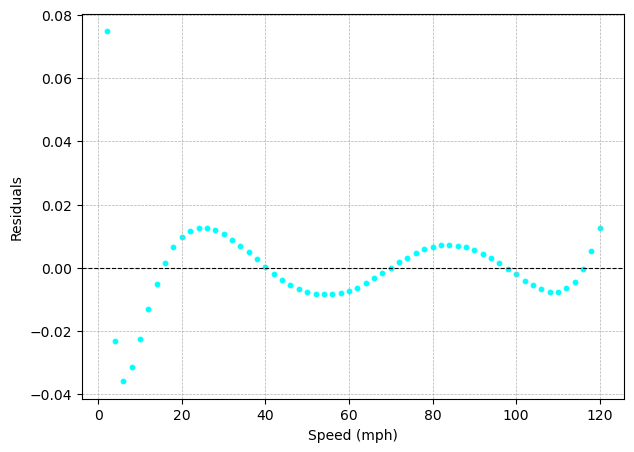

In [18]:
# Function to plot individual residuals for a given polynomial order
def plot_residuals_for_order(order, p, color, index):
    residuals = y - p(x)
    plt.figure(figsize=(7, 5))
    plt.scatter(x, residuals, color=color, s=10)
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.xlabel('Speed (mph)')
    plt.ylabel('Residuals')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.savefig(f"plots/2_residual_plot_deg_{index}.png")
    plt.show()

# Plot residuals for each polynomial order individually
index = 1
for order, (p, color) in enumerate(zip(polynomials, colors), 1):
    plot_residuals_for_order(order, p, color, index)
    index += 1

In [19]:
# Use the function for comparing polynomials
for i in range(4):
    compare_nested(x, y, polynomials[i], polynomials[i+1])

F-test comparing (simple) vs. (complex)

  Simple:   SS=0.231678, DOF=  58
  Complex:  SS=0.044609, DOF=  57
  F-number: 239.0289 
  P-value:  0.0000 
  Random?   0.000%

It is recommended to prefer the complex function.

F-test comparing (simple) vs. (complex)

  Simple:   SS=0.044609, DOF=  57
  Complex:  SS=0.028710, DOF=  56
  F-number: 31.0111 
  P-value:  0.0000 
  Random?   0.000%

It is recommended to prefer the complex function.

F-test comparing (simple) vs. (complex)

  Simple:   SS=0.028710, DOF=  56
  Complex:  SS=0.018474, DOF=  55
  F-number: 30.4733 
  P-value:  0.0000 
  Random?   0.000%

It is recommended to prefer the complex function.

F-test comparing (simple) vs. (complex)

  Simple:   SS=0.018474, DOF=  55
  Complex:  SS=0.011485, DOF=  54
  F-number: 32.8612 
  P-value:  0.0000 
  Random?   0.000%

It is recommended to prefer the complex function.



In [20]:
polynomials_2 = deepcopy(polynomials)

In [21]:
df_raw["Power [kW]"] = df_raw["Consumption_per_mile"] * df_raw["Speed [mph]"]

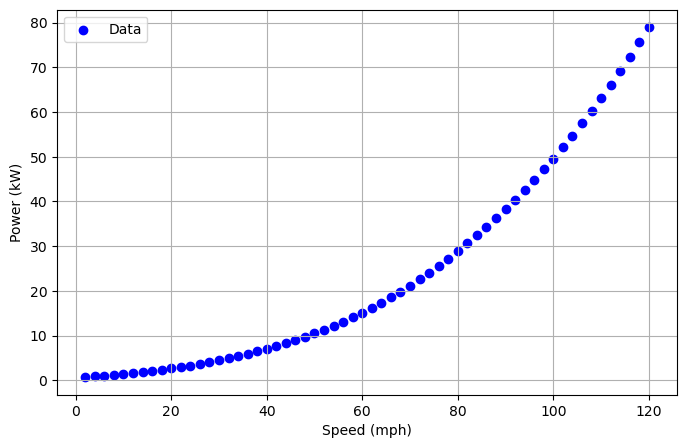

In [22]:
# Visualize the data using the correct column names
plt.figure(figsize=(8, 5))
plt.scatter(df_raw['Speed [mph]'], df_raw["Power [kW]"], color='blue', label='Data')
plt.xlabel('Speed (mph)')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid(True)
plt.savefig("plots/raw_data_3.png")
plt.show()

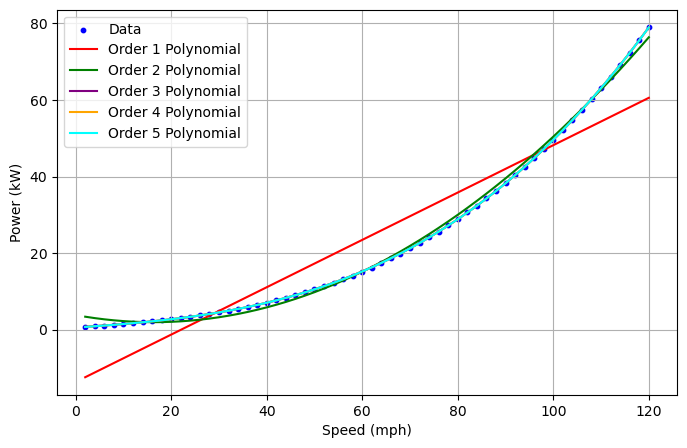

Polynomial([15.7220465 , 32.21057193, 24.33340942,  6.91794484, -0.22992121], domain=[  2., 120.], window=[-1.,  1.], symbol='x')

In [23]:
# Extract the Speed and Range data for fitting
x = df_raw['Speed [mph]'].values
y = df_raw['Power [kW]'].values

# Lists to store results
polynomials = []
mse_values = []

# Fit polynomials of different orders and calculate their MSE
for order in range(1, 6):
    p = Polynomial.fit(x, y, order)
    y_pred = p(x)
    mse = mean_squared_error(y, y_pred)
    
    polynomials.append(p)
    mse_values.append(mse)

# Plot the data and the fitted curves
plt.figure(figsize=(8, 5))
plt.scatter(x, y, color='blue', label='Data', s=10)
colors = ['red', 'green', 'purple', 'orange', 'cyan']
for order, (p, color) in enumerate(zip(polynomials, colors), 1):
    plt.plot(x, p(x), color=color, label=f'Order {order} Polynomial')

plt.xlabel('Speed (mph)')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid(True)
plt.savefig("plots/polynomial_fits_3.png")
plt.show()

mse_values
polynomials[-2]

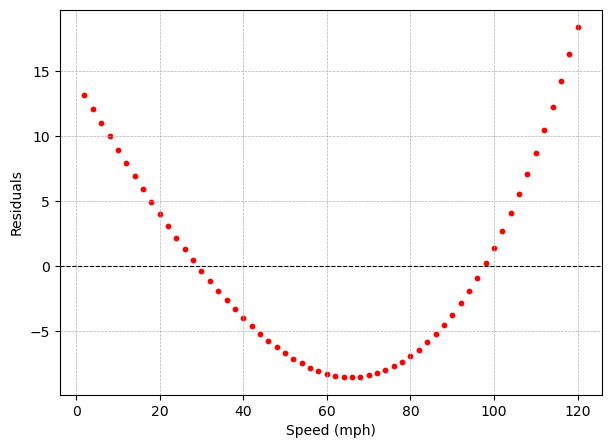

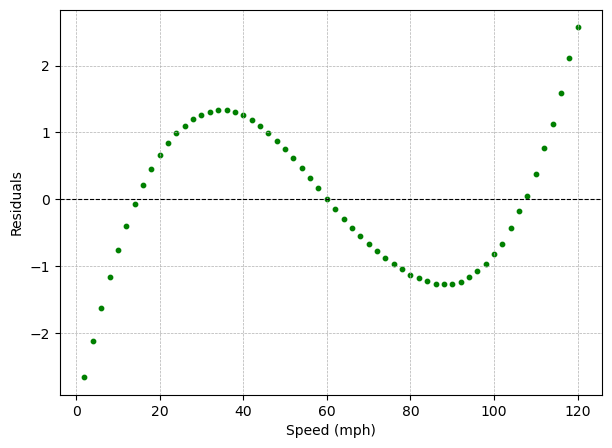

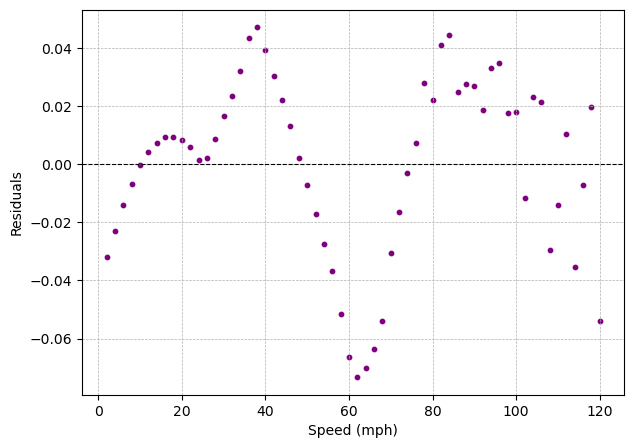

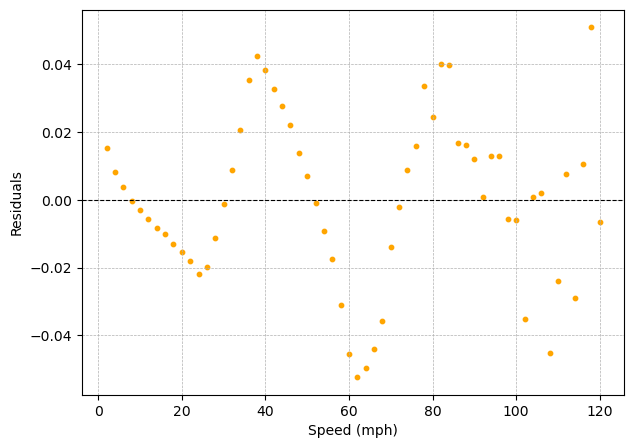

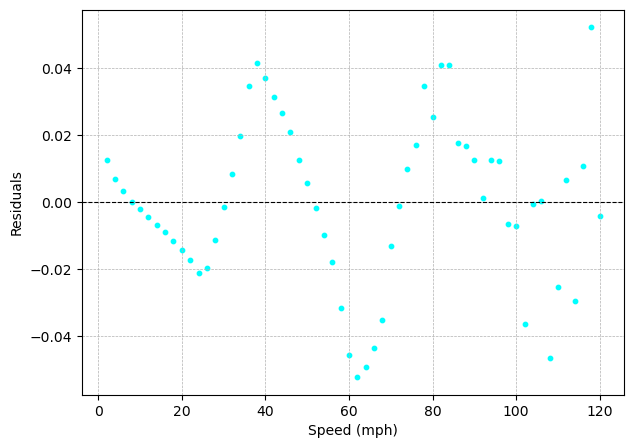

In [24]:
# Function to plot individual residuals for a given polynomial order
def plot_residuals_for_order(order, p, color, index):
    residuals = y - p(x)
    plt.figure(figsize=(7, 5))
    plt.scatter(x, residuals, color=color, s=10)
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.xlabel('Speed (mph)')
    plt.ylabel('Residuals')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.savefig(f"plots/3_residual_plot_deg_{index}.png")
    plt.show()

# Plot residuals for each polynomial order individually
index = 1
for order, (p, color) in enumerate(zip(polynomials, colors), 1):
    plot_residuals_for_order(order, p, color, index)
    index += 1

In [25]:
# Use the function for comparing polynomials
for i in range(4):
    compare_nested(x, y, polynomials[i], polynomials[i+1])

F-test comparing (simple) vs. (complex)

  Simple:   SS=3389.033981, DOF=  58
  Complex:  SS=72.372264, DOF=  57
  F-number: 2612.1846 
  P-value:  0.0000 
  Random?   0.000%

It is recommended to prefer the complex function.

F-test comparing (simple) vs. (complex)

  Simple:   SS=72.372264, DOF=  57
  Complex:  SS=0.056622, DOF=  56
  F-number: 71520.9501 
  P-value:  0.0000 
  Random?   0.000%

It is recommended to prefer the complex function.

F-test comparing (simple) vs. (complex)

  Simple:   SS=0.056622, DOF=  56
  Complex:  SS=0.035735, DOF=  55
  F-number: 32.1475 
  P-value:  0.0000 
  Random?   0.000%

It is recommended to prefer the complex function.

F-test comparing (simple) vs. (complex)

  Simple:   SS=0.035735, DOF=  55
  Complex:  SS=0.035670, DOF=  54
  F-number: 0.0990 
  P-value:  0.7543 
  Random?   75.429%

It is recommended to prefer the simple function.



In [26]:
polynomials[-2]

Polynomial([15.7220465 , 32.21057193, 24.33340942,  6.91794484, -0.22992121], domain=[  2., 120.], window=[-1.,  1.], symbol='x')

In [27]:
polynomials_3 = deepcopy(polynomials)

In [28]:
poly1 = polynomials_1[-1]

In [29]:
poly2 = polynomials_2[-1]

In [30]:
poly3 = polynomials_3[-2]

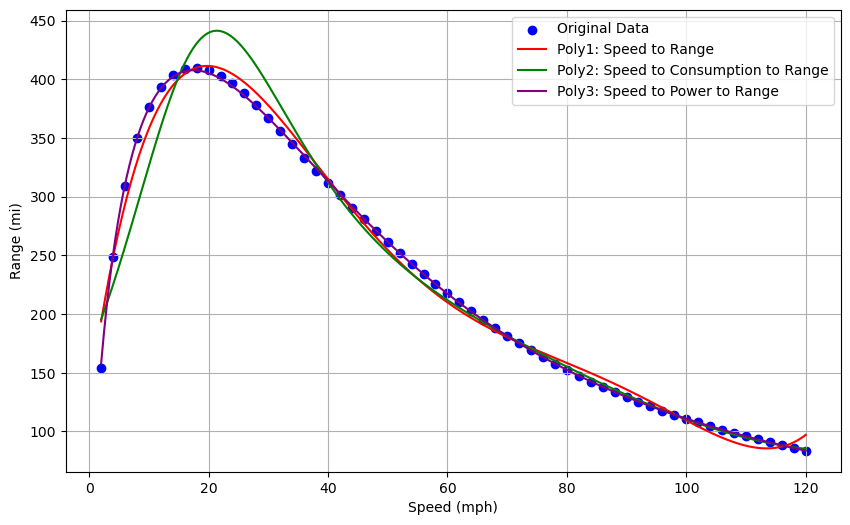

In [33]:
# Extract the Speed and Range data for fitting
x = df_raw['Speed [mph]'].values

# Assuming poly1, poly2, poly3 are defined as per your notebook cells
x_range = np.linspace(min(x), max(x), 500)

# For poly2 and poly3, transform the output of the polynomial to get the range
y_poly1 = poly1(x_range)
y_poly2 = 55 / poly2(x_range)
y_poly3 = 55 * x_range / poly3(x_range)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_raw['Speed [mph]'], df_raw['Range [mi]'], color='blue', label='Original Data')
plt.plot(x_range, y_poly1, label='Poly1: Speed to Range', color='red')
plt.plot(x_range, y_poly2, label='Poly2: Speed to Consumption to Range', color='green')
plt.plot(x_range, y_poly3, label='Poly3: Speed to Power to Range', color='purple')

plt.xlabel('Speed (mph)')
plt.ylabel('Range (mi)')
plt.legend()
plt.grid(True)
plt.savefig("plots/rep_polynomial_fits_compare.png")
plt.show()

In [38]:
speed = 150  # Speed at which to predict the range

# Predicting range using poly1
range_poly1 = poly1(speed)

# Predicting range using poly2
consumption_at_150_mph = poly2(speed)
range_poly2 = 55 / consumption_at_150_mph

# Predicting range using poly3
power_at_150_mph = poly3(speed)
range_poly3 = 55 * speed / power_at_150_mph

print(range_poly1)
print(range_poly2)
print(range_poly3)
print()

964.2347667838767
285.3248925671565
58.00179823392586



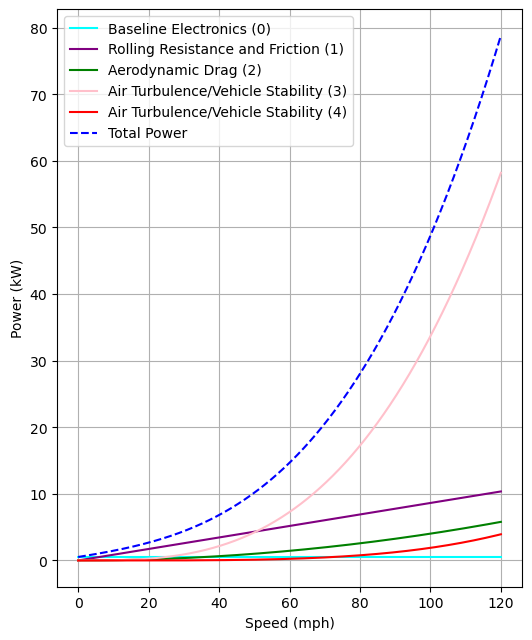

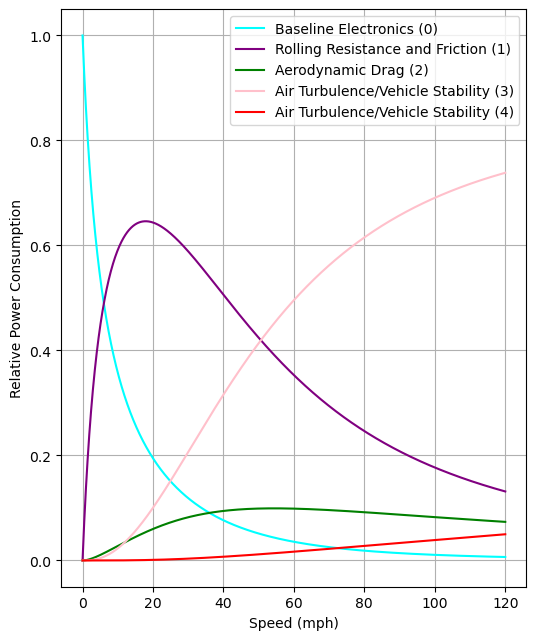

In [50]:
a0, a1, a2, a3, a4 = 0.52238372, 0.08635882, 0.00040258, 0.00003369, 0.22992121 * 0.01694915**4

# Generate a range of speeds for plotting
speeds = np.linspace(0, 120, 2000)  # Speeds from 0 to 120 mph

# Calculate power consumption of each mechanism
baseline_power = a0 * np.ones_like(speeds)
rolling_resistance_power = a1 * speeds
aerodynamic_drag_power = a2 * speeds**2
higher_order_power = a3 * speeds**3 
highest_order_power = a4 * speeds**4
total_power = baseline_power + rolling_resistance_power + aerodynamic_drag_power + higher_order_power + highest_order_power

# Plot (a) Power consumption of each mechanism
plt.figure(figsize=(6, 7.5))
plt.plot(speeds, baseline_power, label='Baseline Electronics (0)', color="cyan")
plt.plot(speeds, rolling_resistance_power, label='Rolling Resistance and Friction (1)', color="purple")
plt.plot(speeds, aerodynamic_drag_power, label='Aerodynamic Drag (2)', color="green")
plt.plot(speeds, higher_order_power, label='Air Turbulence/Vehicle Stability (3)', color="pink")
plt.plot(speeds, highest_order_power, label='Air Turbulence/Vehicle Stability (4)', color="red")
plt.plot(speeds, total_power, label='Total Power', linestyle='--', color="blue")
plt.xlabel('Speed (mph)')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid(True)
plt.savefig("plots/baseline_metrics.png")
plt.show()

# Plot (b) Relative power consumption of each mechanism
relative_baseline_power = baseline_power / total_power
relative_rolling_resistance_power = rolling_resistance_power / total_power
relative_aerodynamic_drag_power = aerodynamic_drag_power / total_power
relative_higher_order_power = higher_order_power / total_power
relative_highest_order_power = highest_order_power / total_power

plt.figure(figsize=(6, 7.5))
plt.plot(speeds, relative_baseline_power, label='Baseline Electronics (0)', color="cyan")
plt.plot(speeds, relative_rolling_resistance_power, label='Rolling Resistance and Friction (1)', color="purple")
plt.plot(speeds, relative_aerodynamic_drag_power, label='Aerodynamic Drag (2)', color="green")
plt.plot(speeds, relative_higher_order_power, label='Air Turbulence/Vehicle Stability (3)', color="pink")
plt.plot(speeds, relative_highest_order_power, label='Air Turbulence/Vehicle Stability (4)', color="red")
plt.xlabel('Speed (mph)')
plt.ylabel('Relative Power Consumption')
plt.legend()
plt.grid(True)
plt.savefig("plots/relative_baseline_metrics.png")
plt.show()